<a href="https://colab.research.google.com/github/comandir26/CNN/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import csv
from typing import Any, Tuple, List

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_full_paths(class_name: str) -> List[str]:
    """
    Возвращает список абсолютных путей для изображений

    Данная функция возвращает список абсолютных путей для всех изображений определенного
    класса, переданного в функцию
    Parameters
    ----------
    class_name : str
      Имя класса
    Returns
    -------
    list
    Список абсолютных путей к изображениям
    """
    full_path = os.path.abspath('drive/MyDrive/cnn/dataset')
    class_path = os.path.join(full_path, class_name)
    image_names = os.listdir(class_path)
    image_full_paths = list(
        map(lambda name: os.path.join(class_path, name), image_names))
    return image_full_paths

In [ ]:
def get_rel_paths(class_name: str) -> List[str]:
    """
    Возвращает список относительных путей путей для изображений

    Данная функция возвращает список относительных путей относительно файла dataset для
    всех изображений определенного класса, переданного в функцию
    Parameters
    ----------
    class_name : str
      Имя класса
    Returns
    -------
    list
    Список относительных путей к изображениям
    """
    rel_path = os.path.relpath('drive/MyDrive/cnn/dataset')
    class_path = os.path.join(rel_path, class_name)
    image_names = os.listdir(class_path)
    image_rel_paths = list(
        map(lambda name: os.path.join(class_path, name), image_names))
    return image_rel_paths

In [ ]:
def create_annotation() -> None:

    class1 = 'polarbear'
    class2 = 'brownbear'

    polarbear_full_paths = get_full_paths(class1)
    polarbear_rel_paths = get_rel_paths(class1)
    brownbear_full_paths = get_full_paths(class2)
    brownbear_rel_paths = get_rel_paths(class2)

    with open('/content/drive/MyDrive/cnn/paths.csv', 'w') as csv_file:
        writer = csv.writer(csv_file, delimiter=',', lineterminator='\r')
        for full_path, rel_path in zip(polarbear_full_paths, polarbear_rel_paths):
            writer.writerow([full_path, rel_path, class1])
        for full_path, rel_path in zip(brownbear_full_paths, brownbear_rel_paths):
            writer.writerow([full_path, rel_path, class2])

In [ ]:
create_annotation()

In [3]:
class MyDataset(Dataset):
    def __init__(self, path_to_annot_file: str, transform: Any=None, train: bool=False, test: bool=False, valid: bool=False) -> None:
        self.path_to_annot_file = path_to_annot_file
        self.data = self.get_data(path_to_annot_file, train, test, valid)
        self.transform = transform

    def get_data(self, path_to_annot_file: str, train: bool=False, test: bool=False, valid: bool=False) -> pd.DataFrame:
        data = pd.read_csv(path_to_annot_file, usecols = (0, 2), names = ('path_to_image', 'label'))
        data = data.sample(frac=1).reset_index(drop=True)
        data['label'] = data['label'].apply(lambda label: 0 if label == 'polarbear' else 1)
        train_size = int(0.8 * data.shape[0])
        test_valid_size = int(0.1 * data.shape[0])
        if train == True:
            data = data.iloc[:train_size, :]
        elif test == True:
            data = data.iloc[train_size:train_size + test_valid_size, :]
        elif valid == True:
            data = data.iloc[train_size + test_valid_size:, :]
        return data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
        path_to_image = self.data.iloc[index, 0]
        image = cv2.cvtColor(cv2.imread(path_to_image), cv2.COLOR_BGR2RGB)
        label = self.data.iloc[index, 1]
        if self.transform:
            image = self.transform(image)
        return image, label


In [4]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize((224, 224)),
                                                    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                                    torchvision.transforms.RandomHorizontalFlip(p=0.3)])

In [43]:
train_data = MyDataset(path_to_annot_file='/content/drive/MyDrive/cnn/paths.csv', transform=transforms, train = True)
test_data = MyDataset(path_to_annot_file='/content/drive/MyDrive/cnn/paths.csv', transform=transforms, test = True)
valid_data = MyDataset(path_to_annot_file='/content/drive/MyDrive/cnn/paths.csv', transform=transforms, valid = True)

In [44]:
len(train_data), len(test_data), len(valid_data)

(1604, 200, 202)

In [45]:
train_data.data['label'].value_counts()

0    816
1    788
Name: label, dtype: int64

In [46]:
test_data.data['label'].value_counts()

1    103
0     97
Name: label, dtype: int64

In [47]:
valid_data.data['label'].value_counts()

0    110
1     92
Name: label, dtype: int64

In [48]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,
                                stride = 2)
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,
                                stride = 2)
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,
                                stride = 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.max_pool = nn.MaxPool2d(2)

        self.fully_connect1 = nn.Linear(576, 10)
        self.fully_connect2 = nn.Linear(10, 1)

    def forward(self, x:torch.tensor) -> torch.tensor:
        output = self.relu(self.conv_1(x))
        output = self.max_pool(output)
        output = self.relu(self.conv_2(output))
        output = self.max_pool(output)
        output = self.relu(self.conv_3(output))
        output = self.max_pool(output)

        output = torch.nn.Flatten()(output)
        output = self.relu(self.fully_connect1(output))
        output = torch.nn.Sigmoid()(self.fully_connect2(output))
        return output

In [12]:
train_loader = DataLoader(dataset=train_data, batch_size=4, shuffle = True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


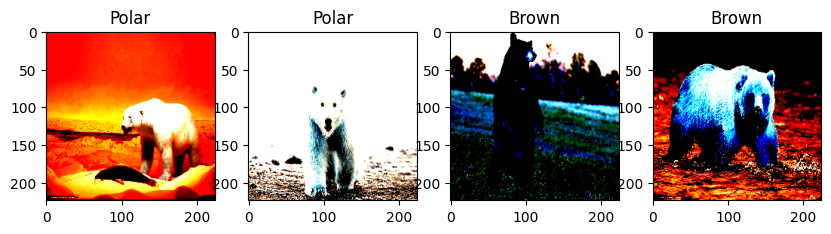

In [13]:
plt.figure(figsize = (10, 5))

for i, sample_batched in enumerate(train_loader):
    if i == 1:
        break
    for j in range(4):
        plt.subplot(1, 4, j + 1)
        plt.title('Polar' if sample_batched[1][j] == 0 else 'Brown')
        plt.imshow(sample_batched[0][j].permute(1, 2, 0).numpy()[:, :, ::-1])

In [55]:
'''
parameters = {'lr': [0.0001, 0.001, 0.01],
              'batch_size' : [8, 16, 24]}
'''
parameters = {'lr': [0.001, 0.01],
              'batch_size' : [24, 32]}

In [57]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = CNN().to(device)

Epoch 1 start
Epoch 1 end
Epoch: 1, train_accuracy: 0.625, train_loss: 0.6363552808761597
Epoch: 1, valid_accuracy: 0.7821782178217822, valid_loss: 0.5171241760253906
Epoch 2 start
Epoch 2 end
Epoch: 2, train_accuracy: 0.92, train_loss: 0.3223055601119995
Epoch: 2, valid_accuracy: 0.9108910891089108, valid_loss: 0.23976531624794006
Epoch 3 start
Epoch 3 end
Epoch: 3, train_accuracy: 0.9349999999999999, train_loss: 0.20108482241630554
Epoch: 3, valid_accuracy: 0.9108910891089108, valid_loss: 0.26014310121536255
Epoch 4 start
Epoch 4 end
Epoch: 4, train_accuracy: 0.9349999999999999, train_loss: 0.19359275698661804
Epoch: 4, valid_accuracy: 0.9405940594059405, valid_loss: 0.19205814599990845
Epoch 5 start
Epoch 5 end
Epoch: 5, train_accuracy: 0.95, train_loss: 0.12502895295619965
Epoch: 5, valid_accuracy: 0.9405940594059405, valid_loss: 0.16516433656215668
LR: 0.001, BS: 24, test_accuracy: 0.96, test_loss: 0.1029486209154129
Epoch 1 start
Epoch 1 end
Epoch: 1, train_accuracy: 0.9550000000

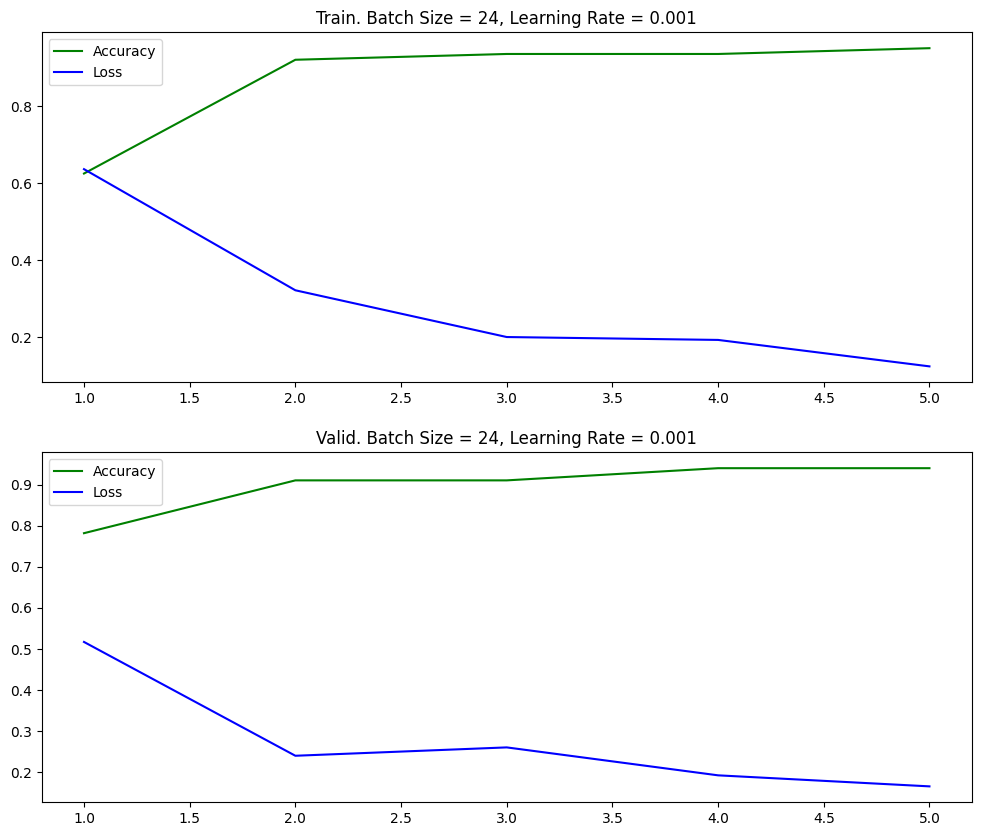

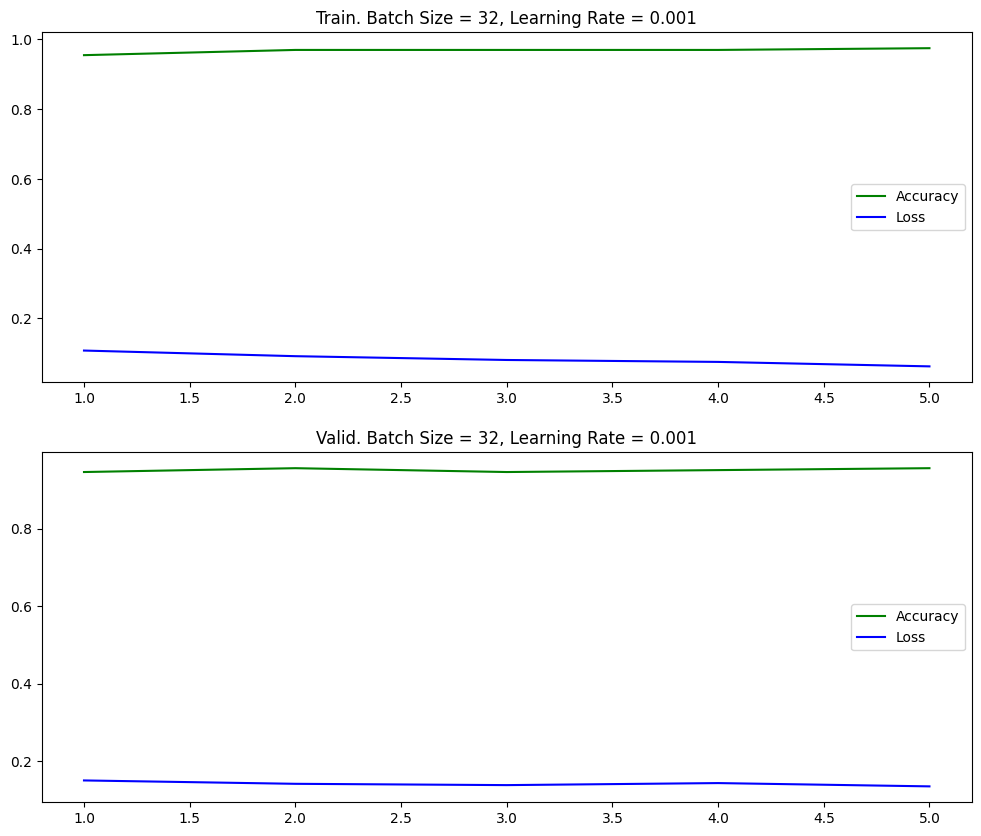

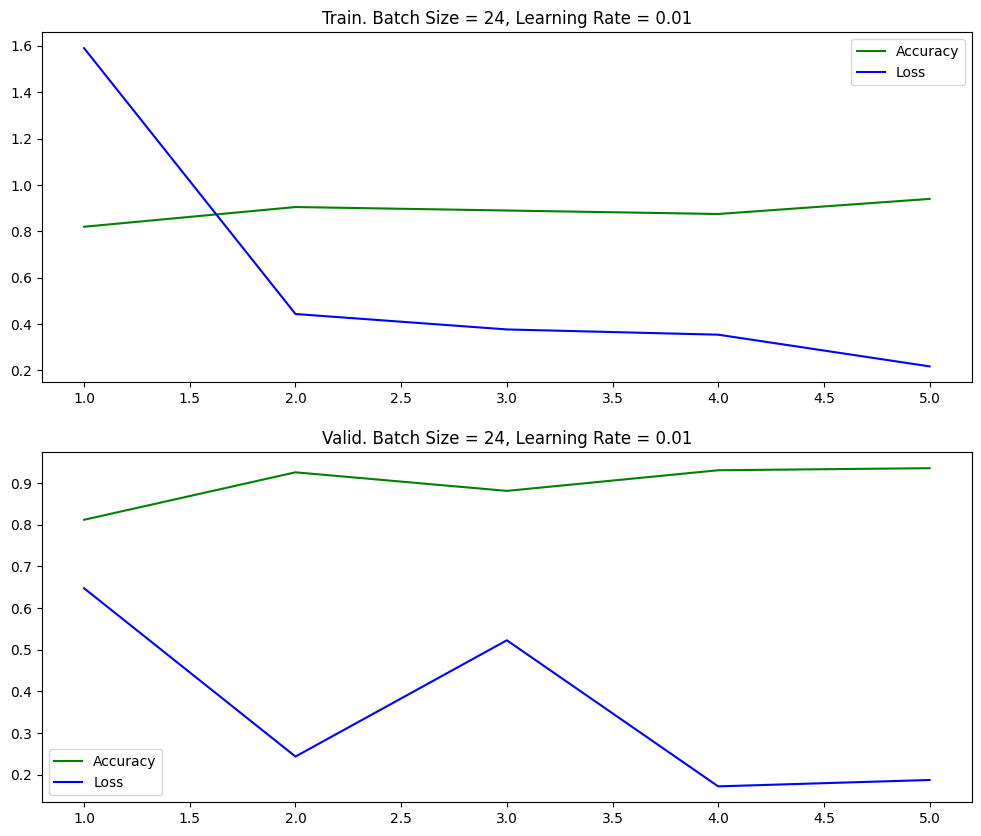

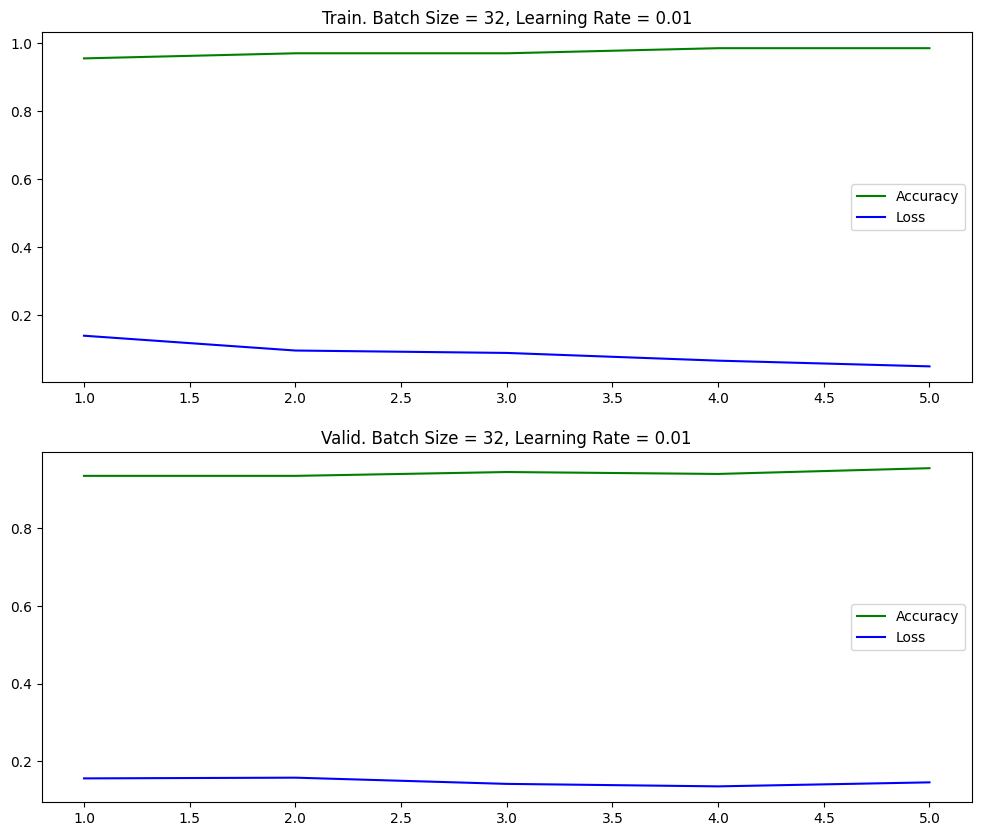

In [58]:
#test_accuracy_values = []
#test_loss_values = []

for lr in parameters['lr']:
    optimizer = optim.Adam(params=model.parameters(), lr=lr)
    criterion = nn.BCELoss(reduction='sum')

    for bs in parameters['batch_size']:

        train_loader = DataLoader(dataset=train_data, batch_size=bs, shuffle = True)
        test_loader = DataLoader(dataset=test_data, batch_size=bs, shuffle = False)
        valid_loader = DataLoader(dataset=valid_data, batch_size=bs, shuffle = False)

        epochs = 5

        train_accuracy_values = []
        train_loss_values = []

        val_accuracy_values = []
        val_loss_values = []

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1} start")
            epoch_loss = 0
            epoch_accuracy = 0

            epoch_val_loss = 0
            epoch_val_accuracy = 0

            for data, label in test_loader:
                data = data.to(device)
                label = label.to(device)

                output = model(data)
                loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(len(label))])).sum()

                epoch_accuracy += acc / len(test_data)
                epoch_loss += loss / len(test_data)

            model.eval()
            #with torch.no_grad():
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                output = model(data)
                loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))
                acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(len(label))])).sum()

                epoch_val_accuracy += acc / len(valid_data)
                epoch_val_loss += loss / len(valid_data)

            val_accuracy_values.append(epoch_val_accuracy)
            val_loss_values.append(epoch_val_loss)

            train_accuracy_values.append(epoch_accuracy)
            train_loss_values.append(epoch_loss)

            print(f"Epoch {epoch + 1} end")

            print('Epoch: {}, train_accuracy: {}, train_loss: {}'.format(epoch + 1, epoch_accuracy, epoch_loss))
            print('Epoch: {}, valid_accuracy: {}, valid_loss: {}'.format(epoch + 1, epoch_val_accuracy, epoch_val_loss))

        train_loss_values = [value.cpu().detach().numpy() for value in train_loss_values]
        val_loss_values = [value.cpu().detach().numpy() for value in val_loss_values]

        plt.figure(figsize=(12,10))

        plt.subplot(2, 1, 1)
        plt.title(f"Train. Batch Size = {bs}, Learning Rate = {lr}")
        plt.plot(range(1, epochs + 1), train_accuracy_values, color = 'green')
        plt.plot(range(1, epochs + 1), train_loss_values, color = 'blue')
        plt.legend(['Accuracy', 'Loss'])

        plt.subplot(2, 1, 2)
        plt.title(f"Valid. Batch Size = {bs}, Learning Rate = {lr}")
        plt.plot(range(1, epochs + 1), val_accuracy_values, color = 'green')
        plt.plot(range(1, epochs + 1), val_loss_values, color = 'blue')
        plt.legend(['Accuracy', 'Loss'])

        model.eval()
        test_loss = 0
        test_accuracy = 0

        #with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

            acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(len(label))])).sum()

            test_accuracy+=acc / len(test_data)
            test_loss+=loss / len(test_data)

        torch.save(model.state_dict(), os.path.join("/content/drive/MyDrive/cnn", f"bs{bs}_lr{lr}_weight.pt"))

        print('LR: {}, BS: {}, test_accuracy: {}, test_loss: {}'.format(lr, bs, test_accuracy, test_loss))

TypeError: ignored

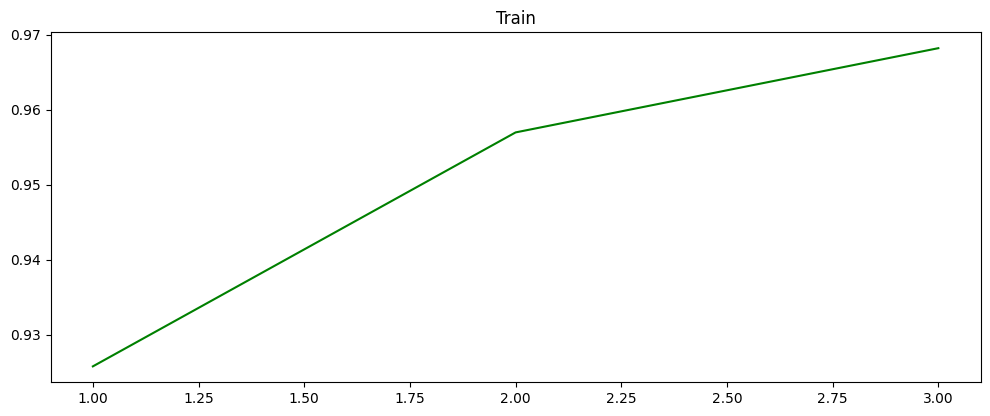

In [ ]:
plt.figure(figsize=(12,10))

plt.subplot(2, 1, 1)
plt.title("Train")
plt.plot(range(1, epochs + 1), train_accuracy_values, color = 'green')
plt.plot(range(1, epochs + 1), train_loss_values, color = 'blue')
plt.legend(['Accuracy', 'Loss'])

plt.subplot(2, 1, 2)
plt.title("Valid")
plt.plot(range(1, epochs + 1), val_accuracy_values, color = 'green')
plt.plot(range(1, epochs + 1), val_loss_values, color = 'blue')
plt.legend(['Accuracy', 'Loss'])

In [ ]:
model.eval()
test_loss = 0
test_accuracy = 0

#with torch.no_grad():
for data, label in test_loader:
    data = data.to(device)
    label = label.to(device)

    output = model(data)
    loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

    acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(len(label))])).sum()

    test_accuracy+=acc / len(test_data)
    test_loss+=loss / len(test_data)

print('LR: {}, BS: {}, test_accuracy: {}, test_loss: {}'.format(0.001, 16, test_accuracy, test_loss))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


LR: 0.001, BS: 16, test_accuracy: 0.9899999999999999, test_loss: 0.034085195511579514


In [ ]:
import random

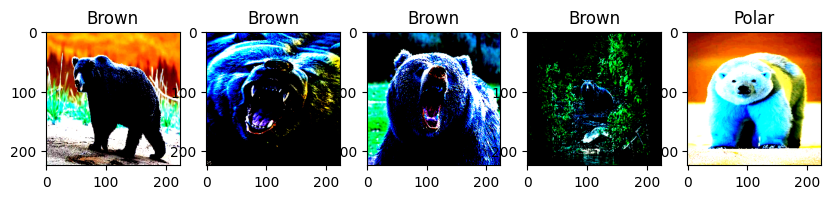

In [ ]:
plt.figure(figsize=(10, 5))

for j in range(5):
  index = random.randint(0, 200)
  plt.subplot(1, 5, j + 1)
  plt.title("Polar" if (1 if  model(test_data[index][0].unsqueeze(dim=0).to(device))[0] >= 0.5 else 0) == 0 else "Brown")
  plt.imshow(test_data[index][0].permute(1, 2, 0).numpy()[:, :, ::-1])